## Online update of scvi-tools models with query datasets

This tutorial covers the usage of the [scArches method](https://www.biorxiv.org/content/10.1101/2020.07.16.205997v1) with SCVI, SCANVI, and TOTALVI. 

This particular workflow is useful in the case where a model is trained on some data (called reference here) and new samples are received (called query). The goal is to analyze these samples in the context of the reference, by mapping the query cells to the same reference latent space. This workflow may also be used in the [scarches](https://scarches.readthedocs.io/) package, but here we demonstrate using only scvi-tools.

### Imports and scvi-tools installation (colab)

In [1]:
import sys

# If True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

if IN_COLAB:
    !pip install --quiet scrublet

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import anndata
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

### Online update of SCVI

Here we use the pancreas dataset described in the scArches manuscript, that is also widely used to benchmark integration methods.

In [3]:
import gdown
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd
To: /home/adam/Documents/software/scvi-tutorials/pancreas.h5ad
126MB [00:02, 62.3MB/s] 


'pancreas.h5ad'

In [4]:
adata_all = sc.read("pancreas.h5ad")
adata = adata_all.raw.to_adata()
print(adata)

AnnData object with n_obs × n_vars = 15681 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'


In [5]:
adata.obs.study.value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

We consider the SS2 and CelSeq2 samples as query, and all the others as reference.

In [6]:
query = np.array([s in ["Pancreas SS2", "Pancreas CelSeq2"] for s in adata.obs.study])

adata_ref = adata[~query].copy()
adata_query = adata[query].copy()

#### Train reference

We train the reference using the standard SCVI workflow, except we add a few non-default parameters that were identified to work well with scArches.

In [7]:
scvi.data.setup_anndata(adata_ref, batch_key="study")

INFO     Using batches from adata.obs["study"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [8]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae_ref = scvi.model.SCVI(
    adata_ref, 
    **arches_params
)
vae_ref.train()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/home/adam/Documents/software/scvi-tools/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 400/400: 100%|██████████| 400/400 [03:32<00:00,  1.88it/s, loss=495, v_num=1]


Now we obtain the latent representation, and use Scanpy to visualize with UMAP.

In [9]:
adata_ref.obsm["X_scVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

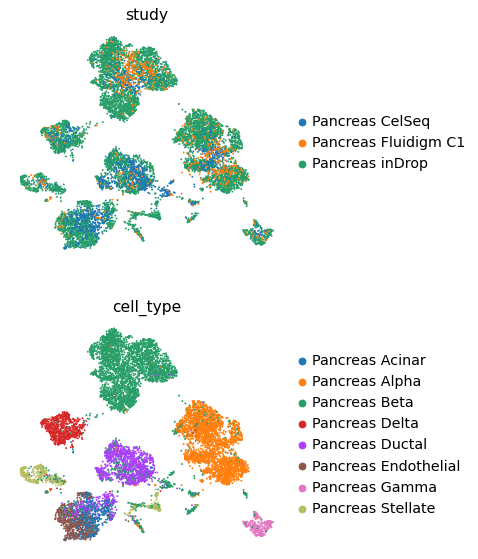

In [10]:
sc.pl.umap(
    adata_ref, 
    color=["study", "cell_type"], 
    frameon=False, 
    ncols=1, 
)

#### Online update with query

We can load a new model with the query data either using 

1. The saved reference model
2. The instantiation of the reference model in memory

In [11]:
# save the reference model
dir_path = "pancreas_model/"
vae_ref.save(dir_path, overwrite=True)

In [12]:
# both are valid
vae_q = scvi.model.SCVI.load_query_data(
    adata_query, 
    dir_path, 
)
vae_q = scvi.model.SCVI.load_query_data(
    adata_query, 
    vae_ref, 
)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 5387 cells, 1000 vars, 5 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

/home/adam/Documents/software/scvi-tools/scvi/data/_anndata.py:810: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
/home/adam/Documents/software/scvi-tools/scvi/data/_anndata.py:810: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


This is a typical `SCVI` object, and after training, can be used in any defined way.

For training the query data, we recommend using a `weight_decay` of 0.0. This ensures the latent representation of the reference cells will remain exactly the same if passing them through this new query model.

In [13]:
vae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))
adata_query.obsm["X_scVI"] = vae_q.get_latent_representation()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/home/adam/Documents/software/scvi-tools/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 200/200: 100%|██████████| 200/200 [00:54<00:00,  3.67it/s, loss=1.13e+03, v_num=1]
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [14]:
sc.pp.neighbors(adata_query, use_rep="X_scVI")
sc.tl.leiden(adata_query)
sc.tl.umap(adata_query)

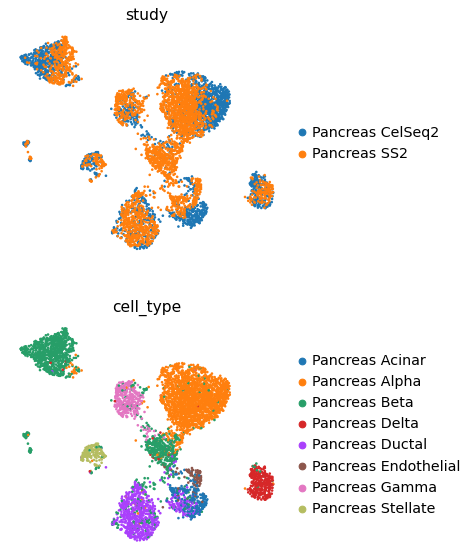

In [15]:
sc.pl.umap(
    adata_query, 
    color=["study", "cell_type"], 
    frameon=False, 
    ncols=1, 
)

#### Visualize reference and query

In [16]:
adata_full = adata_query.concatenate(adata_ref)

The concatenated object has the latent representations of both reference and query, but we are also able to reobtain these values using the query model.

In [17]:
adata_full.obsm["X_scVI"] = vae_q.get_latent_representation(adata_full)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 15681 cells, 1000 vars, 5 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


/home/adam/Documents/software/scvi-tools/scvi/data/_anndata.py:810: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [18]:
sc.pp.neighbors(adata_full, use_rep="X_scVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

... storing 'study' as categorical


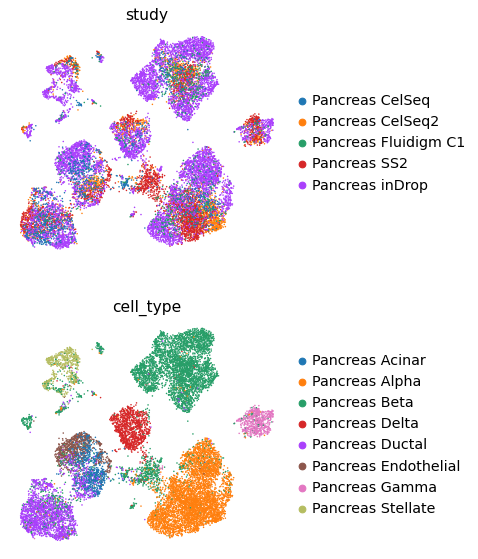

In [19]:
sc.pl.umap(
    adata_full, 
    color=["study", "cell_type"], 
    frameon=False, 
    ncols=1, 
)

### Online update of SCANVI

We'll use the same Pancreas dataset, this time we set it up such that we register that the dataset has labels.

The advantage of SCANVI is that we'll be able to predict the cell type labels of the query dataset. In the case of SCVI, a separate classifier (e.g., nearest-neighbor, random forest, etc.) would have to be trained on the reference latent space.

In [20]:
scvi.data.setup_anndata(adata_ref, batch_key="study", labels_key="cell_type")

INFO     Using batches from adata.obs["study"]                                               
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 3 batches,
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


#### Train reference

`SCANVI` tends to perform better in situations where it has been initialized using a pre-trained `SCVI` model. In this case, we will use `vae_ref` that we have already trained above. In other words, a typical `SCANVI` workflow will be:

```python
scvi_model = SCVI(adata_ref, **arches_params)
scvi_model.train()
scanvi_model = SCANVI.from_scvi_model(scvi_model, "Unknown")
scanvi_model.train()
```

Applying this workflow in the context of this tutorial:

In [21]:
# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_ref,
    unlabeled_category="Unknown",  
)

In [22]:
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                             


GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/home/adam/Documents/software/scvi-tools/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 20/20: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it, loss=555, v_num=1]


In [23]:
adata_ref.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scANVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

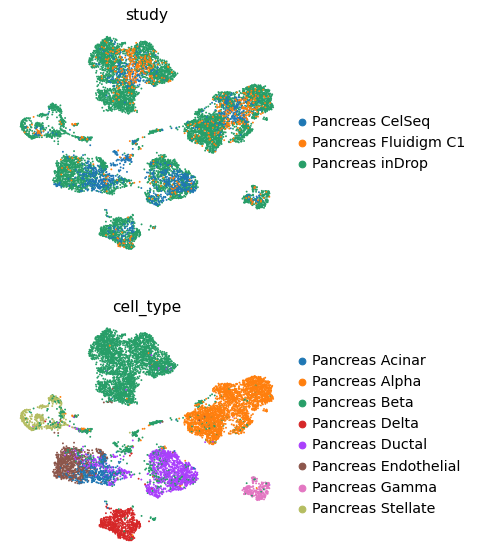

In [24]:
sc.pl.umap(
    adata_ref, 
    color=["study", "cell_type"], 
    frameon=False, 
    ncols=1, 
)

#### Online update with query

In [25]:
dir_path_scan = "pancreas_model_scanvi/"
vae_ref_scan.save(dir_path_scan, overwrite=True)

`SCANVI` is a bit trickier. Because the query data has the true cell type labels, we need to do something a bit hacky and tell the model which cells are labeled and which are unlabeled. We will make this cleaner in a future release.

In [26]:
vae_q = scvi.model.SCANVI.load_query_data(
    adata_query, 
    dir_path_scan, 
)
vae_q._unlabeled_indices = np.arange(adata_query.n_obs)
vae_q._labeled_indices = []

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 5387 cells, 1000 vars, 5 batches, 
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


/home/adam/Documents/software/scvi-tools/scvi/data/_anndata.py:810: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [27]:
vae_q.train(
    max_epochs=100, 
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                            


GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/home/adam/Documents/software/scvi-tools/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 100/100: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s, loss=1.2e+03, v_num=1]


In [28]:
adata_query.obsm["X_scANVI"] = vae_q.get_latent_representation()
adata_query.obs["predictions"] = vae_q.predict()

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


Text(0, 0.5, 'Observed')

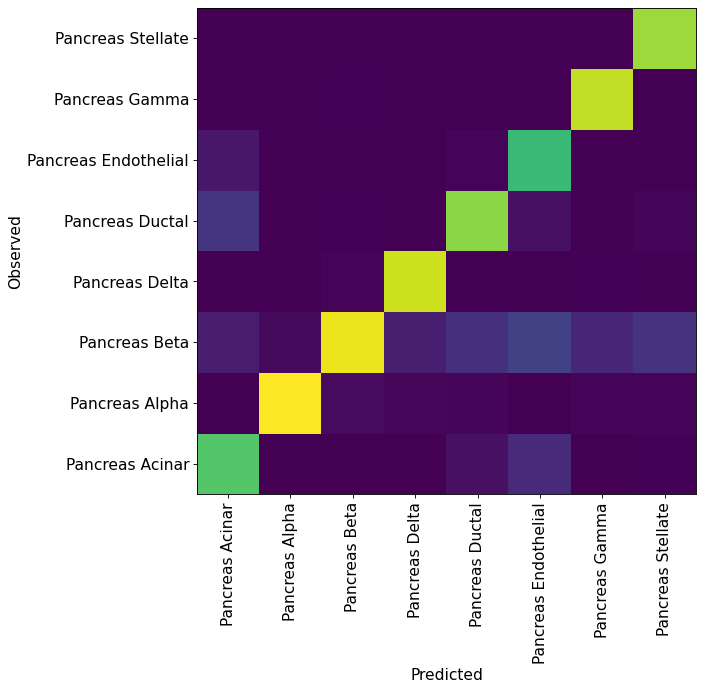

In [29]:
df = adata_query.obs.groupby(["cell_type", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")



#### Analyze reference and query

In [30]:
adata_full = adata_query.concatenate(adata_ref)

This just makes a column in the anndata corresponding to if the data come from the reference or query sets.

In [31]:
adata_full.obs.batch.cat.rename_categories(["Query", "Reference"], inplace=True)

In [32]:
full_predictions = vae_q.predict(adata_full)
print("Acc: {}".format(np.mean(full_predictions == adata_full.obs.cell_type)))

# adata_full.obs["predictions"] = ["Known"] * adata_ref.n_obs + list(adata_query.obs["predictions"].to_numpy())
adata_full.obs["predictions"] = full_predictions

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 15681 cells, 1000 vars, 5 batches,
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


/home/adam/Documents/software/scvi-tools/scvi/data/_anndata.py:810: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


Acc: 0.8991773483833939


In [33]:
sc.pp.neighbors(adata_full, use_rep="X_scANVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

... storing 'study' as categorical
... storing 'predictions' as categorical


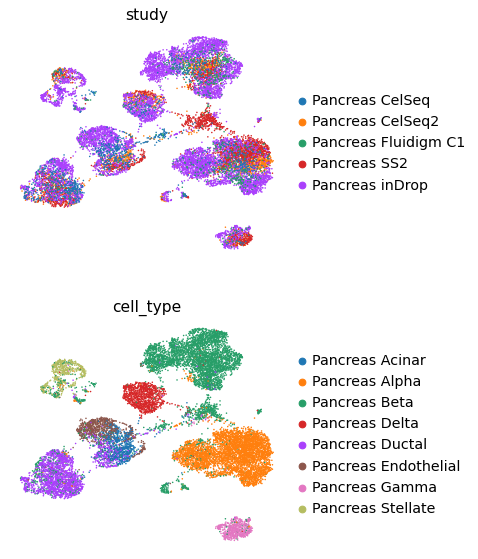

In [34]:
sc.pl.umap(
    adata_full, 
    color=["study", "cell_type"], 
    frameon=False, 
    ncols=1, 
)

Trying to set attribute `.uns` of view, copying.


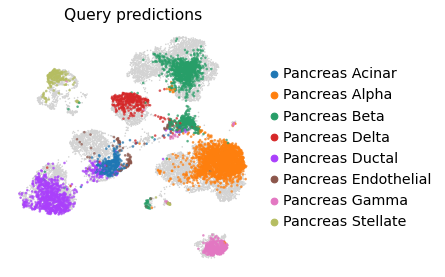

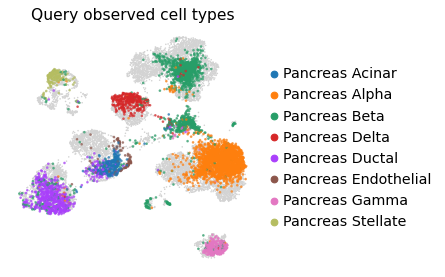

In [35]:
ax = sc.pl.umap(
    adata_full, 
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[:adata_query.n_obs], 
    color=["predictions"], 
    frameon=False, 
    title="Query predictions",
    ax=ax,
    alpha=0.7
)

ax = sc.pl.umap(
    adata_full, 
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[:adata_query.n_obs], 
    color=["cell_type"], 
    frameon=False, 
    title="Query observed cell types",
    ax=ax,
    alpha=0.7
)

### Online update of TOTALVI

This workflow works very similarly for TOTALVI. Here we demonstrate how to build a CITE-seq reference and use scRNA-seq only data as the query.

#### Assemble data

For totalVI, we will treat two CITE-seq PBMC datasets from 10X Genomics as the reference. These datasets were already filtered for outliers like doublets, as described in the totalVI manuscript. There are 14 proteins in the reference.

In [36]:
adata_ref = scvi.data.pbmcs_10x_cite_seq(run_setup_anndata=False)

INFO     File data/pbmc_10k_protein_v3.h5ad already downloaded                               
INFO     File data/pbmc_5k_protein_v3.h5ad already downloaded                                


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In general, there will be some necessary data wrangling. For example, we need to provide totalVI with some protein data -- and when it's all zeros, totalVI identifies that the protein data is missing in this "batch".

It could have also been the case that only some of the protein data was missing, in which case we would add zeros for each of the missing proteins.

In [37]:
adata_query = scvi.data.dataset_10x("pbmc_10k_v3")
adata_query.obs["batch"] = "PBMC 10k (RNA only)"
# put matrix of zeros for protein expression (considered missing)
pro_exp = adata_ref.obsm["protein_expression"]
data = np.zeros((adata_query.n_obs, pro_exp.shape[1]))
adata_query.obsm["protein_expression"] = pd.DataFrame(columns=pro_exp.columns, index=adata_query.obs_names, data = data)

INFO     File data/10X/pbmc_10k_v3/filtered_feature_bc_matrix.h5 already downloaded          


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


We do some light QC filtering on the query dataset (doublets, mitochondrial, etc.)

In [38]:
import scrublet as scr
scrub = scr.Scrublet(adata_query.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata_query = adata_query[~predicted_doublets].copy()

adata_query.var['mt'] = adata_query.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_query, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_query = adata_query[adata_query.obs.pct_counts_mt < 15, :].copy()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 4.9%
Estimated detectable doublet fraction = 56.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.8%
Elapsed time: 8.8 seconds


Now to concatenate the objects, which intersects the genes properly.

In [39]:
adata_full = anndata.concat([adata_ref, adata_query])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


And split them back up into reference and query (but now genes are properly aligned between objects).

In [40]:
adata_ref = adata_full[np.logical_or(adata_full.obs.batch == "PBMC5k", adata_full.obs.batch == "PBMC10k")].copy()
adata_query = adata_full[adata_full.obs.batch == "PBMC 10k (RNA only)"].copy()


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


We run gene selection on the reference, because that's all that will be avaialble to us at first.

In [41]:
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True,
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Finally, we use these selected genes for the query dataset as well.

In [42]:
adata_query = adata_query[:, adata_ref.var_names].copy()

#### Train reference

In [43]:
scvi.data.setup_anndata(
    adata_ref,
    batch_key="batch",
    protein_expression_obsm_key="protein_expression"
)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Using protein expression from adata.obsm['protein_expression']                      
INFO     Using protein names from columns of adata.obsm['protein_expression']                
INFO     Successfully registered anndata object containing 10849 cells, 4000 vars, 2 batches,
         1 labels, and 14 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


In [45]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
)
vae_ref = scvi.model.TOTALVI(
    adata_ref, 
    **arches_params
)

/home/adam/.pyenv/versions/scvi-tools-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
vae_ref.train()

/home/adam/.pyenv/versions/scvi-tools-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 400/400: 100%|██████████| 400/400 [03:59<00:00,  1.67it/s, loss=1.23e+03, v_num=1]


In [47]:
adata_ref.obsm["X_totalVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_totalVI")
sc.tl.umap(adata_ref, min_dist=0.4)

/home/adam/.pyenv/versions/scvi-tools-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/adam/.pyenv/versions/scvi-tools-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
... storing 'batch' as categorical


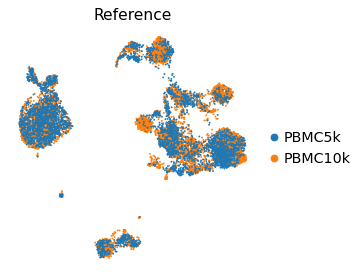

In [48]:
sc.pl.umap(
    adata_ref,
    color=["batch"],
    frameon=False,
    ncols=1,
    title="Reference"
)

In [49]:
dir_path = "saved_model/"
vae_ref.save(dir_path, overwrite=True)

#### Online update with query

In [50]:
vae_q = scvi.model.TOTALVI.load_query_data(
    adata_query, 
    dir_path, 
    freeze_expression=True
)

INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Found batches with missing protein expression                                       
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'protein_expression']                                                               
INFO     Successfully registered anndata object containing 10131 cells, 4000 vars, 3 batches,
         1 labels, and 14 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


In [52]:
vae_q.train(200, plan_kwargs=dict(weight_decay=0.0))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 200/200: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s, loss=753, v_num=1]


In [53]:
adata_query.obsm["X_totalVI"] = vae_q.get_latent_representation()
sc.pp.neighbors(adata_query, use_rep="X_totalVI")
sc.tl.umap(adata_query, min_dist=0.4)

/home/adam/.pyenv/versions/scvi-tools-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Impute protein data for query and visualize

Now that we have updated with the query, we can impute the proteins that were observed in the reference, using the `transform_batch` parameter.

In [54]:
_, imputed_proteins = vae_q.get_normalized_expression(
    adata_query,
    n_samples=25,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

/home/adam/.pyenv/versions/scvi-tools-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Very quickly we can identify the major expected subpopulations of B cells, CD4 T cells, CD8 T cells, monocytes, etc.

... storing 'batch' as categorical


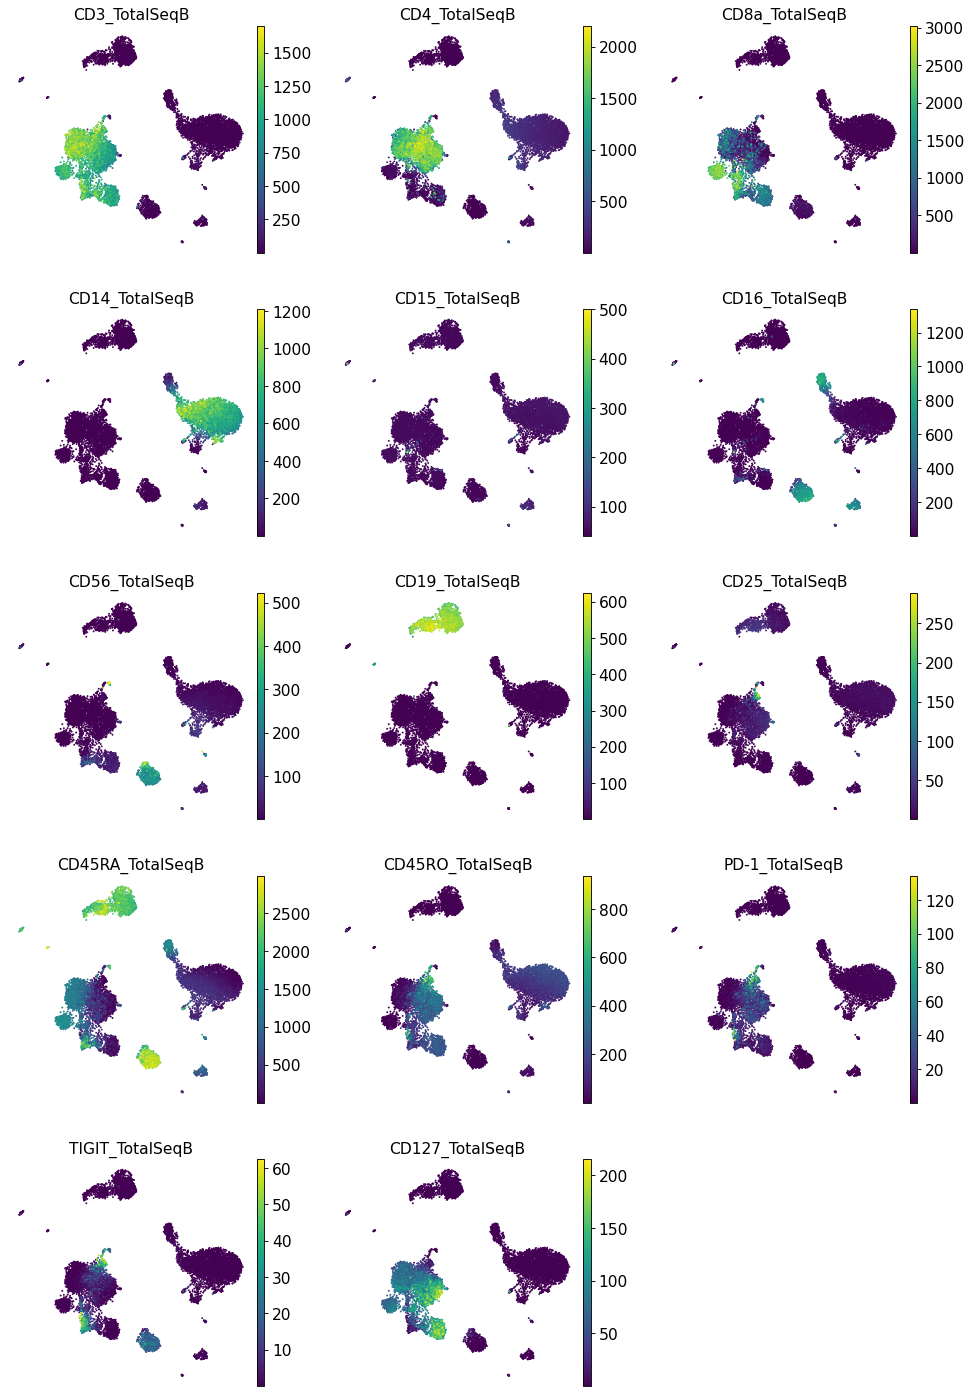

In [55]:
adata_query.obs = pd.concat([adata_query.obs, imputed_proteins], axis=1)

sc.pl.umap(
    adata_query,
    color=imputed_proteins.columns,
    frameon=False,
    ncols=3,
)

#### Visualize reference and query

In [56]:
adata_full_new = adata_query.concatenate(adata_ref, batch_key="none")

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [57]:
adata_full_new.obsm["X_totalVI"] = vae_q.get_latent_representation(adata_full_new)
sc.pp.neighbors(adata_full_new, use_rep="X_totalVI")
sc.tl.umap(adata_full_new, min_dist=0.3)

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Found batches with missing protein expression                                       
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'protein_expression']                                                               
INFO     Successfully registered anndata object containing 20980 cells, 4000 vars, 3 batches,
         1 labels, and 14 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


In [58]:
_, imputed_proteins_all = vae_q.get_normalized_expression(
    adata_full_new,
    n_samples=25,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

for i, p in enumerate(imputed_proteins_all.columns):
    adata_full_new.obs[p] = imputed_proteins_all[p].to_numpy().copy()

/home/adam/.pyenv/versions/scvi-tools-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/adam/.pyenv/versions/scvi-tools-dev/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'batch' as categorical


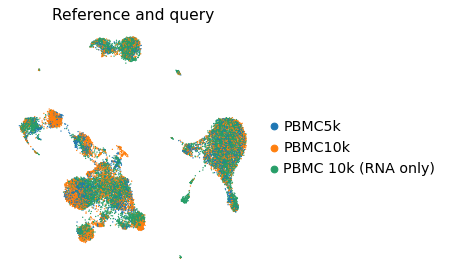

In [59]:
perm_inds = np.random.permutation(np.arange(adata_full_new.n_obs))
sc.pl.umap(
    adata_full_new[perm_inds],
    color=["batch"],
    frameon=False,
    ncols=1,
    title="Reference and query"
)

... storing 'batch' as categorical


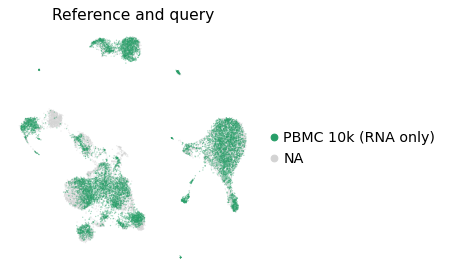

In [60]:
ax = sc.pl.umap(
    adata_full_new,
    color="batch",
    groups=["PBMC 10k (RNA only)"],
    frameon=False,
    ncols=1,
    title="Reference and query",
    alpha=0.4
)

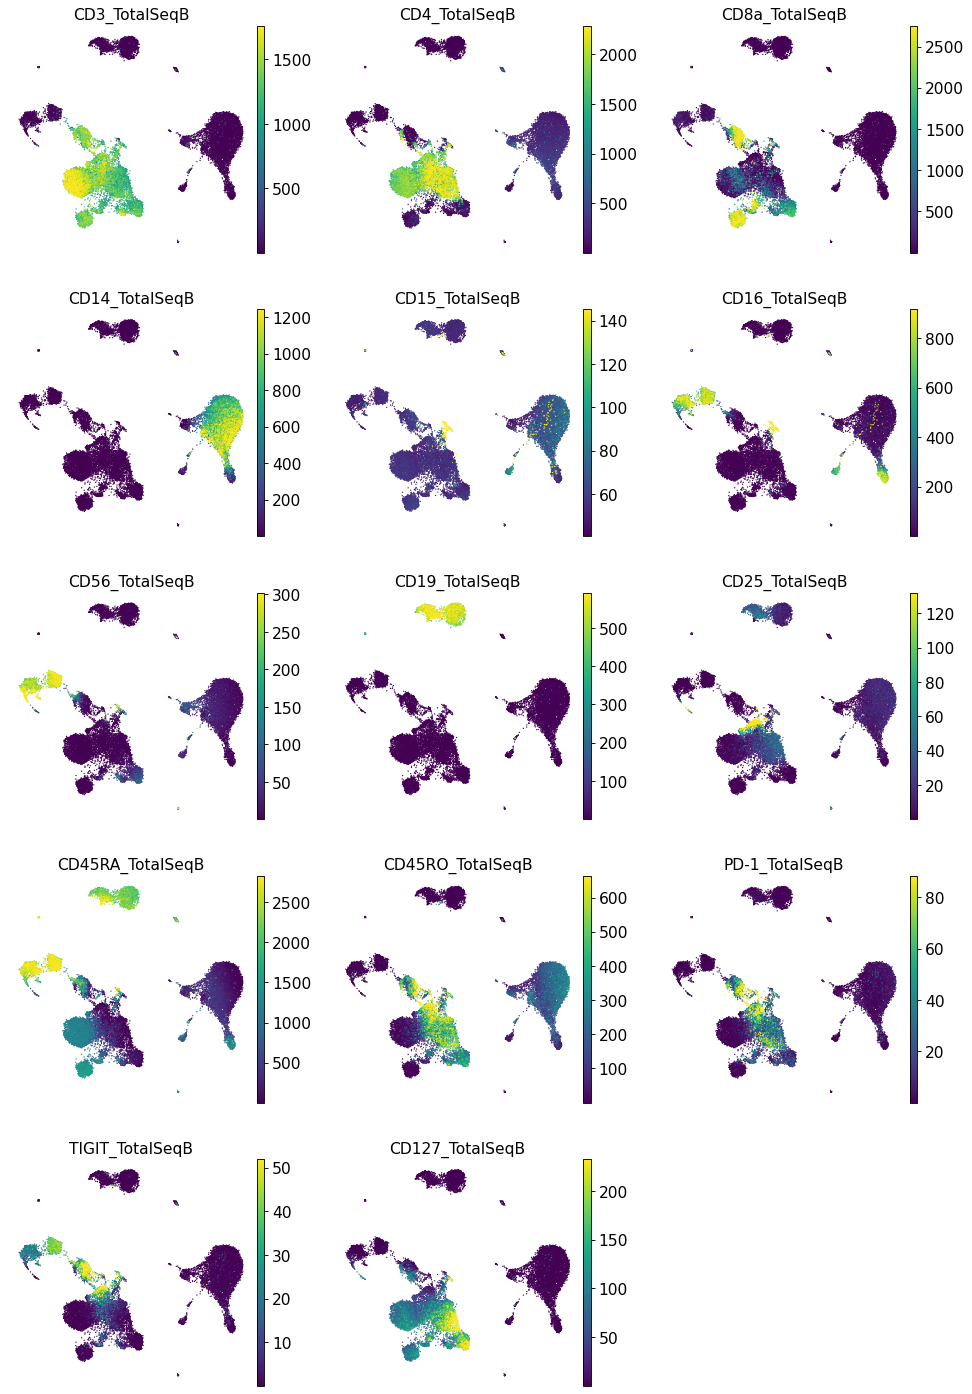

In [61]:
sc.pl.umap(
    adata_full_new,
    color=imputed_proteins_all.columns,
    frameon=False,
    ncols=3,
    vmax="p99"
)